In [2]:
import cv2
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

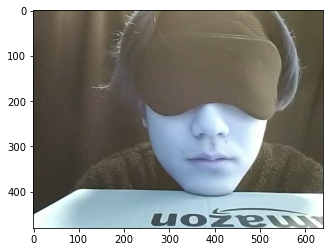

In [8]:
cap = cv2.VideoCapture("sample.mp4")

#1フレーム目の映像
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
if ret:
    plt.imshow(frame)
    plt.show()
cap.release()
cv2.destroyAllWindows()

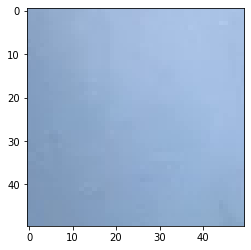

In [11]:
cap = cv2.VideoCapture("sample.mp4")
roi = (280, 260, 330, 310) #計測部位の入力

#計測部位の表示
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
if ret:
    select_roi = frame[roi[1]: roi[3], roi[0]: roi[2]]
    plt.imshow(select_roi)
    plt.show()
cap.release()
cv2.destroyAllWindows()

In [12]:
cap = cv2.VideoCapture("sample.mp4")

#右頬の緑の平均輝度値
g_list = []
while (cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    roi = (280, 260, 330, 310) #計測部位の入力
    roi = frame[roi[1]:roi[3], roi[0]:roi[2]]
#右頬の関心領域を青と緑と赤のチャンネルに分ける
    b, g, r = cv2.split(roi)
    g_list.append(255 - g.mean(
cap.release()

In [13]:
#listからndarrayへ
g_array = np.array(g_list)

#FIRフィルタの変数
sample_rate = 30
dt = 1 / 30
nyq = sample_rate / 2
#ハイパスフィルタ
hf = 3
#ローパスフィルタ
lf = 0.7

#カットオフ周波数（正規化０から１になるように）
wh = hf /nyq
wl = lf / nyq
#フィルタ係数の数
numtaps = 161
#FIRフィルタの応答の遅れ
delay = (numtaps - 1) / 2 * dt

#FIRフィルタ
fir = signal.firwin(numtaps, cutoff=[wl, wh], window="hanning", pass_zero=False)
gf = signal.lfilter(fir, 1, g_array)

In [14]:
# 脈波の谷検出（左右10個と比べて）
minimal_idx_gf = signal.argrelmin(gf, order=10)
bottom_number = minimal_idx_gf[0]
bottom_number = np.delete(bottom_number, slice(0, 5))
bottom_count = len(bottom_number)

# 心拍変動
i = 0
bottom_interval = []
while i < bottom_count - 1:
    mi = (bottom_number[i + 1] - bottom_number[i])
    bottom_interval.append(mi)
    i += 1

heart_rate_interval = np.array(bottom_interval) * dt

# 心拍数
hri_ave = np.average(heart_rate_interval)
heart_rate = 60 / hri_ave

In [15]:
print(heart_rate)
print(heart_rate_interval)

78.81355932203391
[0.43333333 1.03333333 0.76666667 0.4        0.46666667 0.8
 0.7        0.7        0.73333333 0.6        0.9        0.83333333
 0.66666667 0.7        1.06666667 0.53333333 0.5        0.43333333
 0.53333333 1.2        0.43333333 0.7        1.         0.46666667
 0.83333333 0.9        1.2        0.43333333 0.4        0.73333333
 1.3        1.         0.83333333 0.93333333 0.8        0.53333333
 0.76666667 0.63333333 0.96666667 0.66666667 0.8        0.8
 0.4        0.86666667 0.93333333 0.93333333 0.56666667 0.96666667
 0.9        0.83333333 0.83333333 0.96666667 0.76666667 0.96666667
 0.8        1.         0.66666667 0.86666667 0.73333333 0.66666667
 0.9        0.5       ]


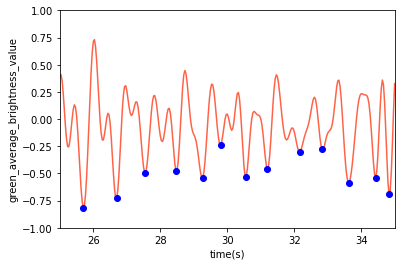

In [16]:
x = np.linspace(1, len(gf), len(gf))
dt = 1 / 30
t = (x * dt) - dt
tf = t - delay

plt.plot(tf, gf, label="fir", c="tomato")  # FIRフィルタのプロット
plt.plot(tf[minimal_idx_gf], gf[minimal_idx_gf], 'bo', label='peak_minimal')  # 谷
plt.xlabel("time(s)")  # x軸のtitle
plt.ylabel("green_average_brightness_value")  # y軸のtitle
plt.xlim(25, 35)  # x軸の範囲
plt.ylim(-1.0, 1.0)  # y軸の範囲
plt.show()